In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np



## Bài 1:
Code from scratch hàm transposed convolution

In [ ]:


# Define the transposed convolution operation
def transposed_convolution(input, kernel, stride=1, padding=0):
    # Get the input shape
    batch_size, in_channels, in_height, in_width = input.shape

    # Get the kernel shape
    out_channels, in_channels, kernel_height, kernel_width = kernel.shape

    # Calculate the output shape
    out_height = (in_height - 1) * stride - 2 * padding + kernel_height
    out_width = (in_width - 1) * stride - 2 * padding + kernel_width

    # Initialize the output tensor
    output = torch.zeros((batch_size, out_channels, out_height, out_width))

    # Perform the transposed convolution
    for b in range(batch_size):
        for c_out in range(out_channels):
            for h_out in range(out_height):
                for w_out in range(out_width):
                    for c_in in range(in_channels):
                        for kh in range(kernel_height):
                            for kw in range(kernel_width):
                                h_in = h_out + kh * stride
                                w_in = w_out + kw * stride
                                if h_in >= 0 and h_in < in_height and w_in >= 0 and w_in < in_width:
                                    output[b, c_out, h_out, w_out] += input[b, c_in, h_in, w_in] * kernel[c_out, c_in, kh, kw]

    return output

# Test the transposed convolution
input = torch.rand(1, 1, 4, 4)
kernel = torch.rand(1, 1, 3, 3)
stride = 2
padding = 1
output = transposed_convolution(input, kernel, stride, padding)

print("Input shape:", input.shape)
print("Kernel shape:", kernel.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([1, 1, 4, 4])
Kernel shape: torch.Size([1, 1, 3, 3])
Output shape: torch.Size([1, 1, 7, 7])


## Bài 2:
Cho dataset cifar-10
- Cho noise cho dataset được sample từ normal distribution (mean = 0, variance = 0.1)
- Dùng cấu trúc autoencoder để denoise lại bức ảnh về như ban đầu
- Visualize ảnh ban đầu, ảnh được thêm noise, và ảnh sau khi denoise.


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 0.0108
Epoch [2/10], Loss: 0.0066
Epoch [3/10], Loss: 0.0051
Epoch [4/10], Loss: 0.0056
Epoch [5/10], Loss: 0.0052
Epoch [6/10], Loss: 0.0051
Epoch [7/10], Loss: 0.0049
Epoch [8/10], Loss: 0.0045
Epoch [9/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0047


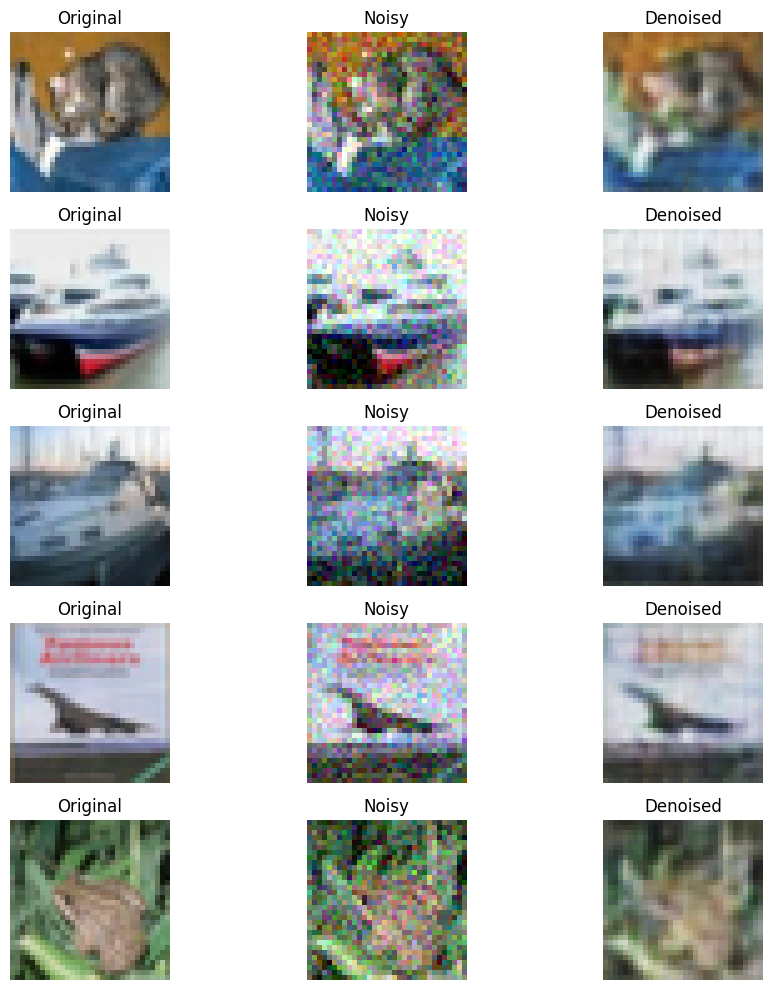

In [ ]:

# Step 1: Tạo noise cho dataset
def add_noise(images, mean, variance):
    noise = torch.randn_like(images) * variance + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)  # Giới hạn giá trị pixel trong khoảng [0, 1]
    return noisy_images


# Step 2: Xây dựng mô hình autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Step 3: Tải dữ liệu CIFAR-10
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Step 4: Chuẩn bị dữ liệu và mô hình
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Huấn luyện mô hình
num_epochs = 10

for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        # Step 1: Thêm noise vào ảnh
        noisy_images = add_noise(images, mean=0, variance=0.1).to(device)

        # Step 2: Đưa noisy_images qua autoencoder
        outputs = model(noisy_images)

        # Step 3: Tính loss và cập nhật weights
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

# Step 6: Đánh giá mô hình
# Step 6: Đánh giá mô hình
model.eval()

# Lấy một batch hình ảnh từ test set
for images, _ in test_loader:
    images = images.to(device)

    # Thêm noise vào hình ảnh
    noisy_images = add_noise(images, mean=0, variance=0.1).to(device)

    # Đưa noisy_images qua autoencoder để tái tạo lại ảnh ban đầu
    outputs = model(noisy_images)

    # Chỉ xử lý batch đầu tiên
    break

# Chuyển đổi tensor thành numpy array và định dạng lại hình ảnh
images = images.cpu().numpy().transpose(0, 2, 3, 1)
noisy_images = noisy_images.cpu().numpy().transpose(0, 2, 3, 1)
outputs = outputs.cpu().detach().numpy().transpose(0, 2, 3, 1)

# Hiển thị hình ảnh gốc, hình ảnh có noise và hình ảnh đã tái tạo
n = 5  # Số lượng hình ảnh cần hiển thị
fig, axes = plt.subplots(n, 3, figsize=(10, 10))
for i in range(n):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(noisy_images[i])
    axes[i, 1].set_title('Noisy')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(outputs[i])
    axes[i, 2].set_title('Denoised')
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

##  Bài 3:
Cho dataset cifar-10
- Giảm chiều dữ liệu về dạng 2d của 1 ảnh bất kỳ bằng 2 phương pháp: PCA và convolution AE.
- Visualize và so sánh 2 phương pháp


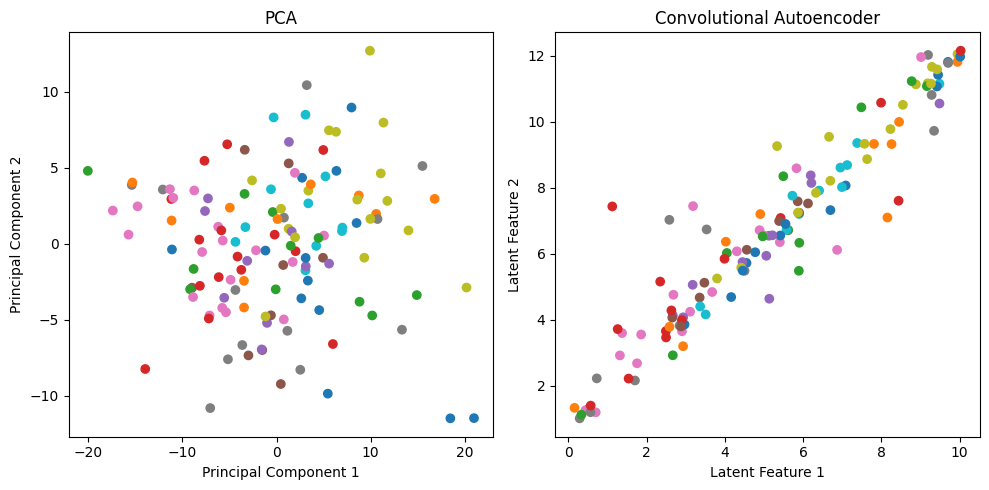

In [24]:
# Giảm chiều dữ liệu bằng PCA
def apply_pca(images, n_components):
    # Reshape images to 2D
    images_2d = images.view(images.size(0), -1).numpy()

    # Apply PCA
    pca = PCA(n_components=n_components)
    images_pca = pca.fit_transform(images_2d)

    return images_pca


#  Huấn luyện mô hình Convolutional AE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss and perform optimization
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



#  Giảm chiều dữ liệu bằng Convolutional AE
def apply_ae(images, model):
    images = images.to(device)
    outputs = model.encoder(images)
    outputs = outputs.view(outputs.size(0), -1).cpu().detach().numpy()
    return outputs


# Lấy một ảnh từ test set và áp dụng PCA và Convolutional AE
test_loader_iter = iter(test_loader)
images, targets = next(test_loader_iter)
image_pca = apply_pca(images, n_components=2)
image_ae = apply_ae(images, model)

# Visualize và so sánh kết quả
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(image_pca[:, 0], image_pca[:, 1], c=targets[:image_pca.shape[0]], cmap='tab10')
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(image_ae[:, 0], image_ae[:, 1], c=targets[:image_ae.shape[0]], cmap='tab10')
plt.title('Convolutional Autoencoder')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.tight_layout()
plt.show()
